In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Importação da base de dados

In [19]:
dfResults = pd.read_excel("dados.xlsx")
dfResults.value_counts("Results")
#Results: Baixo = 0; Medio = 1; Alto = 2

y = dfResults['Results']
X = dfResults.drop(['record_id', 'Anticorpos', 'Results'], axis=1)

Separação entre grupo de treino, validação e teste

In [20]:
#Treino (train) = 60%
#Validação (eval) = 20%
#Teste (test) = 20% 
X_train_eval, X_test, y_train_eval, y_test = train_test_split(
    X, y, random_state=0, test_size=0.20)

X_train, X_eval, y_train, y_eval = train_test_split(
    X_train_eval, y_train_eval, random_state=0, test_size=0.25)

Normalização das classes

In [21]:
scaler = MinMaxScaler() 

X_train_normalized = scaler.fit_transform(X_train)
X_eval_normalized = scaler.transform(X_eval)
X_test_normalized = scaler.transform(X_test)

Optei por não fazer o balanceamento das classes, pois obtive melhores resultados sem necessitar balancea-las ja que reduzia bastante meu N amostral

In [ ]:
## Balanceamento das classes (não foi necessário)

# under_sampler = RandomUnderSampler(random_state=42)

# X_res_normalized, y_res_normalized = under_sampler.fit_resample(X_train_normalized, y_train)


Modelos escolhidos:
- Support Vector Machine (SVM)
- Regressão Logística (RL)
- Gradient Boosting (GB)

Escolha dos melhores hiperparâmetros (Grid Search)

In [ ]:
# SVM
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [0.01, 0.1, 1, 'auto'],
    'degree': [2, 3, 4],
}

grid_search = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5), verbose=1, n_jobs=-1)

grid_search.fit(X_train_normalized, y_train)
print("SVM", grid_search.best_params_)

#--------------------------------------------
#Regressão logística (RL)
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5), verbose=1, n_jobs=-1)

grid_search.fit(X_train_normalized, y_train)
print("RL", grid_search.best_params_)

#--------------------------------------------
#Gradient Boosting (GB)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5), verbose=1, n_jobs=-1)

grid_search.fit(X_train_normalized, y_train)
print("GB", grid_search.best_params_)

Validação dos modelos com os melhores hiperparâmetros

In [22]:
# SVM - melhores hiperparametros
svm_model = SVC(C=0.01, kernel='poly', degree=2, gamma=1)
svm_model.fit(X_train_normalized, y_train)
y_pred_svm = svm_model.predict(X_eval_normalized)

# Logistic regression - melhores hiperparametros
logistic_model = LogisticRegression(C=0.1, penalty='l1', solver='saga', max_iter=100)
logistic_model.fit(X_train_normalized, y_train)
y_pred_reg = logistic_model.predict(X_eval_normalized)

# GradientBoosting - melhores hiperparametros
gb_model = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=1,
    n_estimators=200,
    subsample=0.9,
    n_jobs=-1
)

gb_model.fit(X_train_normalized, y_train)
y_pred_gb = gb_model.predict(X_eval_normalized)



Resultados da validação

In [23]:
# SVM
print("SVM")
print('Precision score %s' % precision_score(y_eval, y_pred_svm, average=None))
print('Recall score %s' % recall_score(y_eval, y_pred_svm, average=None))
print('F1-score score %s' % f1_score(y_eval, y_pred_svm, average=None))
print('Accuracy score %s' % accuracy_score(y_eval, y_pred_svm))
print("-------------------")

# Logistic Regression
print("RL")
print('Precision score %s' % precision_score(y_eval, y_pred_reg, average=None))
print('Recall score %s' % recall_score(y_eval, y_pred_reg, average=None))
print('F1-score score %s' % f1_score(y_eval, y_pred_reg, average=None))
print('Accuracy score %s' % accuracy_score(y_eval, y_pred_reg))
print("-------------------")

# GradientBoosting
print("GB")
print('Precision score %s' % precision_score(y_eval, y_pred_gb, average=None))
print('Recall score %s' % recall_score(y_eval, y_pred_gb, average=None))
print('F1-score score %s' % f1_score(y_eval, y_pred_gb, average=None))
print('Accuracy score %s' % accuracy_score(y_eval, y_pred_gb))

SVM
Precision score [0.78321678 0.75428571]
Recall score [0.77642981 0.76153846]
F1-score score [0.77980853 0.75789474]
Accuracy score 0.7693710118505014
-------------------
RL
Precision score [0.78285714 0.70979021]
Recall score [0.71230503 0.78076923]
F1-score score [0.74591652 0.74358974]
Accuracy score 0.7447584320875114
-------------------
GB
Precision score [0.78044597 0.76264591]
Recall score [0.78856153 0.75384615]
F1-score score [0.78448276 0.7582205 ]
Accuracy score 0.772105742935278


Teste com o melhor modelo em relação a acurácia (Gradient Boosting)

In [24]:
#Testando o melhor modelo no teste
# GradientBoosting - melhores hiperparametros
gb_model = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=1,
    n_estimators=200,
    subsample=0.9,
    n_jobs=-1
)

gb_model.fit(X_train_normalized, y_train)
y_pred_gb = gb_model.predict(X_test_normalized)

# GradientBoosting
print("GB")
print('Precision score %s' % precision_score(y_test, y_pred_gb, average=None))
print('Recall score %s' % recall_score(y_test, y_pred_gb, average=None))
print('F1-score score %s' % f1_score(y_test, y_pred_gb, average=None))
print('Accuracy score %s' % accuracy_score(y_test, y_pred_gb))

GB
Precision score [0.81260097 0.74112735]
Recall score [0.80223285 0.7537155 ]
F1-score score [0.80738363 0.74736842]
Accuracy score 0.7814207650273224


Construção do Heatmap

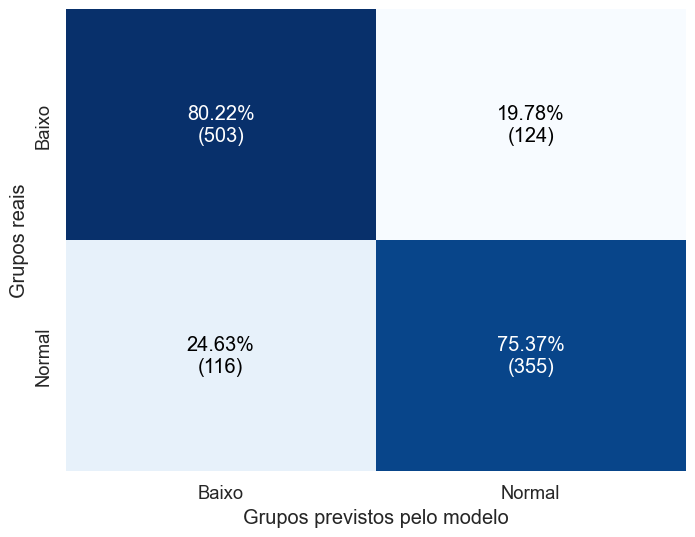

In [25]:
#GB - melhor modelo
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plotMatrix(y_test, y_pred_gb, labels = ["Baixo", "Normal"], figName = "ConfusionMatrix"):

  conf_matrix = confusion_matrix(y_test, y_pred_gb)
  conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1, keepdims=True)

  # Configuração do gráfico
  class_names = labels
  sns.set(font_scale=1.2)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix_percent, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
  for i in range(len(class_names)):
      for j in range(len(class_names)):
          if conf_matrix_percent[i, j] > 0.7:
            color = "white"
          else:
            color="black"
          plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2%}\n({conf_matrix[i, j]})", ha="center", va="center", color=color)

  plt.xlabel('Grupos previstos pelo modelo')
  plt.ylabel('Grupos reais')
  plt.savefig(f'{figName}.png', dpi=300)
  plt.show()

plotMatrix(y_test, y_pred_gb, figName = "RLMatrix")

Gráfico de importância das Features

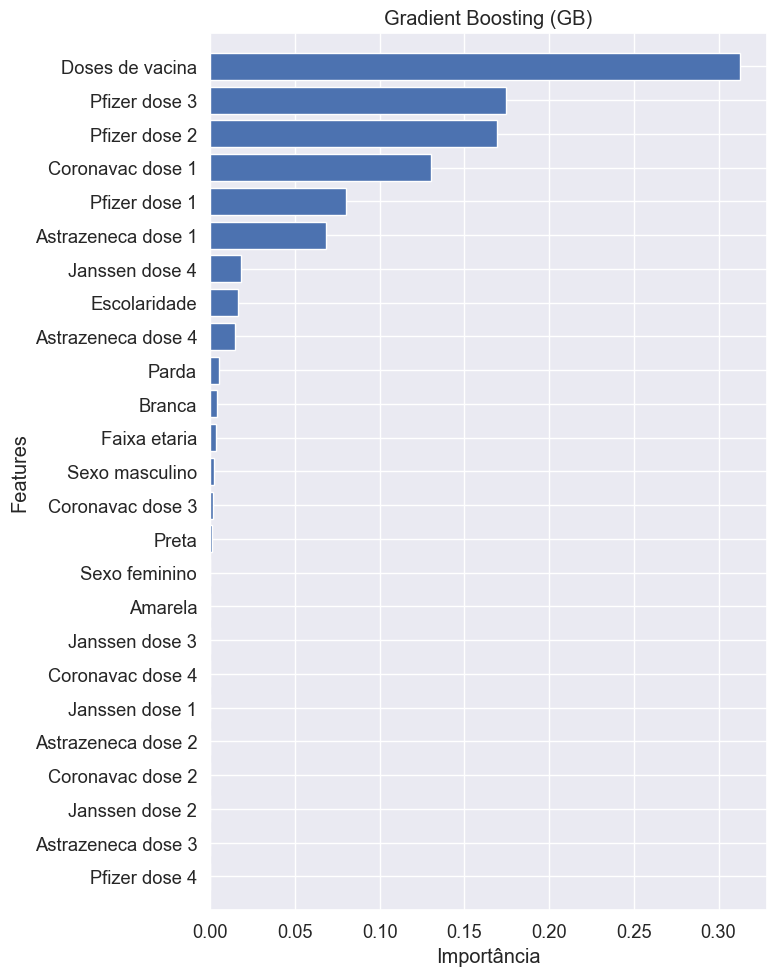

In [26]:
#GB
#Importância das features
# Calcular a importância das características
importances = gb_model.feature_importances_
feature_names = X.columns

# Ordenar as importâncias e os nomes das características
indices = np.argsort(importances)
sorted_importances = importances[indices]
sorted_feature_names = feature_names[indices]

# Criar o gráfico
plt.figure(figsize=(8, 10))
plt.title("Gradient Boosting (GB)")
plt.barh(range(X.shape[1]), sorted_importances, color="b", align="center")
plt.yticks(range(X.shape[1]), sorted_feature_names)
plt.ylim([-1, X.shape[1]])
plt.xlabel('Importância')
plt.ylabel('Features')
plt.tight_layout()
plt.show()